# 타이타닉 생존자 예측(Titanic Passengers Survival) with XGBoost & Grid Search

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [2]:
train_df = pd.read_csv("../data/titanic_train.csv")
test_df  = pd.read_csv("../data/titanic_test.csv")
(len(train_df), len(test_df))
#행중심으로 합친다

(891, 418)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
titanic_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=True ) #concat 더하기 판다스에있는걸로 pd.concat 앞에가 큰거부터 axis=0행으로
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


* 데이터 종류

Variable Name | Description
------------------|-------------
PassengerId | Passenger Id (unique)
Survived | Survived (1) or died (0)
Pclass | Passenger's class (1/Upper, 2/Middle, 3/Lower)
Name | Passenger's Name (common Surname may be possible)
Sex | Passenger's sex (just 'male' & 'female')
Age (20% missing values) | Passenger's age
SibSp | Number of siblings/spouses aboard
Parch | Number of parents/children aboard
Ticket | Ticket number (many of the ticket seem to be common for a group of passengers, i.e., they are group ticket)
Fare (1 missing in 'test') | Fare
Cabin (77% missing in both 'train'& 'test') | Cabin
Embarked (2 missing values in 'train') | Port of embarkation

In [8]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## EDA 및 전처리

### Embarked 값 처리

<Axes: xlabel='Embarked', ylabel='count'>

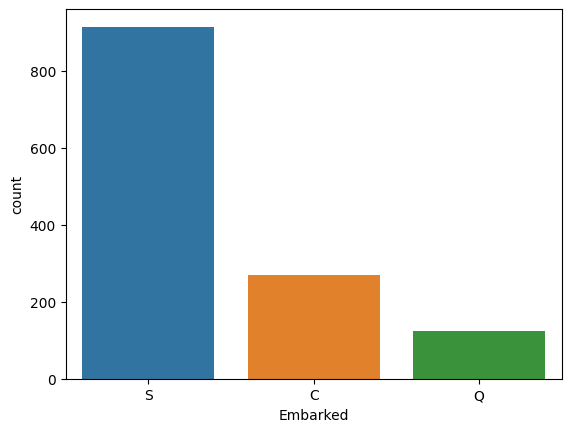

In [9]:
sns.countplot(x='Embarked', data=titanic_df)

In [10]:
# Embarked의 NA 값은 S로 채우기
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(value="S")

In [11]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1309 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Title 정리

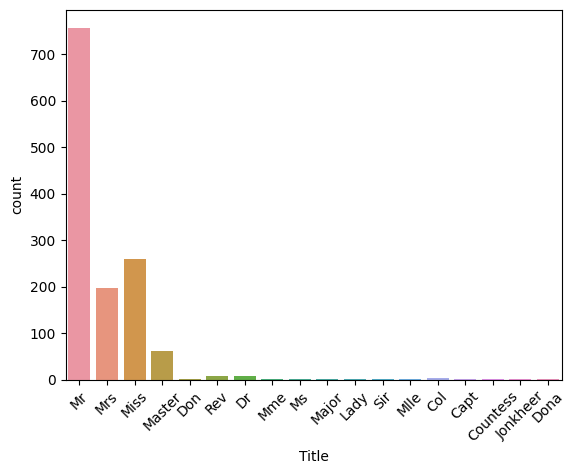

In [14]:
import re
titanic_df['Title'] = titanic_df.Name.apply(lambda x: re.search('([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=titanic_df) #이문구는 그림만
plt.xticks(rotation=45); #numpy 세부세팅할떄 사용 ,이문구는 내부세팅

In [13]:
titanic_df['Title']

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
         ...  
1304        Mr
1305      Dona
1306        Mr
1307        Mr
1308    Master
Name: Title, Length: 1309, dtype: object

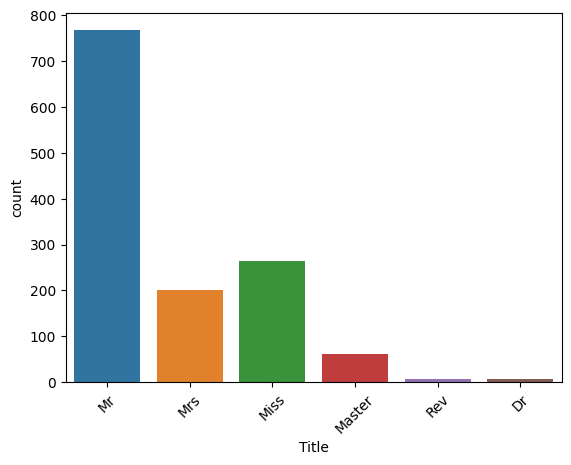

In [15]:
titanic_df['Title'] = titanic_df['Title'].replace({'Mlle': 'Miss', 
                                                   'Major': 'Mr', 
                                                   'Col': 'Mr', 
                                                   'Sir': 'Mr', 
                                                   'Don': 'Mr', 
                                                   'Mme': 'Miss', 
                                                   'Jonkheer': 'Mr', 
                                                   'Lady': 'Mrs', 
                                                   'Capt': 'Mr', 
                                                   'Countess': 'Mrs', 
                                                   'Ms': 'Miss', 
                                                   'Dona': 'Mrs'})
sns.countplot(x='Title', data=titanic_df);
plt.xticks(rotation=45);

### Age 정리

In [16]:
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    # value
    age_to_impute = titanic_df.groupby('Title')['Age'].median()[titles.index(title)]
    titanic_df.loc[(titanic_df['Age'].isnull()) & (titanic_df['Title'] == title), 'Age'] = age_to_impute

### SibSp, Parch 정리

In [17]:
titanic_df['Familial'] = (titanic_df['SibSp'] + titanic_df['Parch']) > 0

In [18]:
medianFare = titanic_df[titanic_df['Pclass'] == 3]['Fare'].median()
titanic_df['Fare'] = titanic_df['Fare'].fillna(value = medianFare)

### Categorizing

In [34]:
# Age (하한 / 상한) (17/80)
custom_bucket_array = np.linspace(0,80,17)
titanic_df["CatAge"] = pd.cut(titanic_df["Age"], custom_bucket_array)
labels, _ = pd.factorize(titanic_df["CatAge"])
titanic_df["CatAge"] = labels

In [36]:
# Fare
custom_bucket_array = np.linspace(0, 520, 53)
titanic_df["CatFare"] = pd.cut(titanic_df["Fare"], custom_bucket_array)
labels, _ = pd.factorize(titanic_df["CatFare"])
titanic_df["CatFare"] = labels

In [39]:
# 성별 및 기타...
titanic_df["SexBool"] = titanic_df["Sex"].map({"male": 0, "female": 1})
titanic_df["EmbarkedInt"] = titanic_df["Embarked"].map({"S":0, "C":1, "Q":2})
titanic_df["TitleInt"] = titanic_df["Title"].map({"Mr":0, "Mrs":1, "Miss":2, "Master":3, "Rev":4, "Dr":5})

## 기존 데이터로 되돌리기

In [40]:
# Get back the features engineered train_df & test_df
train_len = len(train_df)
train_df = titanic_df.loc[titanic_df['PassengerId'] <= train_len]
test_df = titanic_df.loc[titanic_df['PassengerId'] > train_len].iloc[:, titanic_df.columns != 'Survived']
(len(train_df), len(test_df))

(891, 418)

## 모델 학습

In [41]:
# X, y
Columns = ['SexBool', 'Pclass', 'Fare', 'CatAge', 'Familial', 'EmbarkedInt', 'TitleInt']
Label = 'Survived'
X_train = train_df.loc[:, train_df.columns != 'Survived']
y_train = train_df['Survived']

In [42]:
model = XGBClassifier()

In [43]:
both_scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss':'neg_log_loss'}
params = {'n_estimators': [100, 200, 500, 1000, 1500],
          'learning_rate': [0.05, 0.1, 0.2],
          #'max_depth':[3, 4, 5]
          }

In [44]:
clf = GridSearchCV(model, params, cv=5, scoring=both_scoring, refit='AUC', return_train_score=True)
clf.fit(X_train[Columns], y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': [100, 200, 500, 1000, 1500]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'Loss': 'neg_log_loss'})

In [45]:
print((clf.best_score_, clf.best_params_))
print("="*30)

print("Grid scores on training data:")
means = clf.cv_results_['mean_test_AUC']
stds = clf.cv_results_['std_test_AUC']
log_losses = clf.cv_results_['std_test_Loss']

for mean, std, log_loss, params in zip(means, stds, log_losses, clf.cv_results_['params']): #zip 하나에컨테이너처럼작동시켜 for문돌린다?
    print(f"AUC Score: {mean} (+/-{std*2}); Log Loss: {log_loss} for {params}")

(0.8708888783420683, {'learning_rate': 0.05, 'n_estimators': 100})
Grid scores on training data:
AUC Score: 0.8708888783420683 (+/-0.06822487883082527); Log Loss: 0.05949732872455452 for {'learning_rate': 0.05, 'n_estimators': 100}
AUC Score: 0.8671204726587302 (+/-0.06408486138759964); Log Loss: 0.0688286625952168 for {'learning_rate': 0.05, 'n_estimators': 200}
AUC Score: 0.8635206288701796 (+/-0.05843443662974563); Log Loss: 0.07592861837611663 for {'learning_rate': 0.05, 'n_estimators': 500}
AUC Score: 0.858085391207649 (+/-0.058496011084614385); Log Loss: 0.08296963639188573 for {'learning_rate': 0.05, 'n_estimators': 1000}
AUC Score: 0.8560090872117785 (+/-0.05965332718994506); Log Loss: 0.08909897668828291 for {'learning_rate': 0.05, 'n_estimators': 1500}
AUC Score: 0.8684051909555206 (+/-0.06653320319771916); Log Loss: 0.06890901798209319 for {'learning_rate': 0.1, 'n_estimators': 100}
AUC Score: 0.8664787027695002 (+/-0.05584639443776417); Log Loss: 0.07401595900772752 for {'l

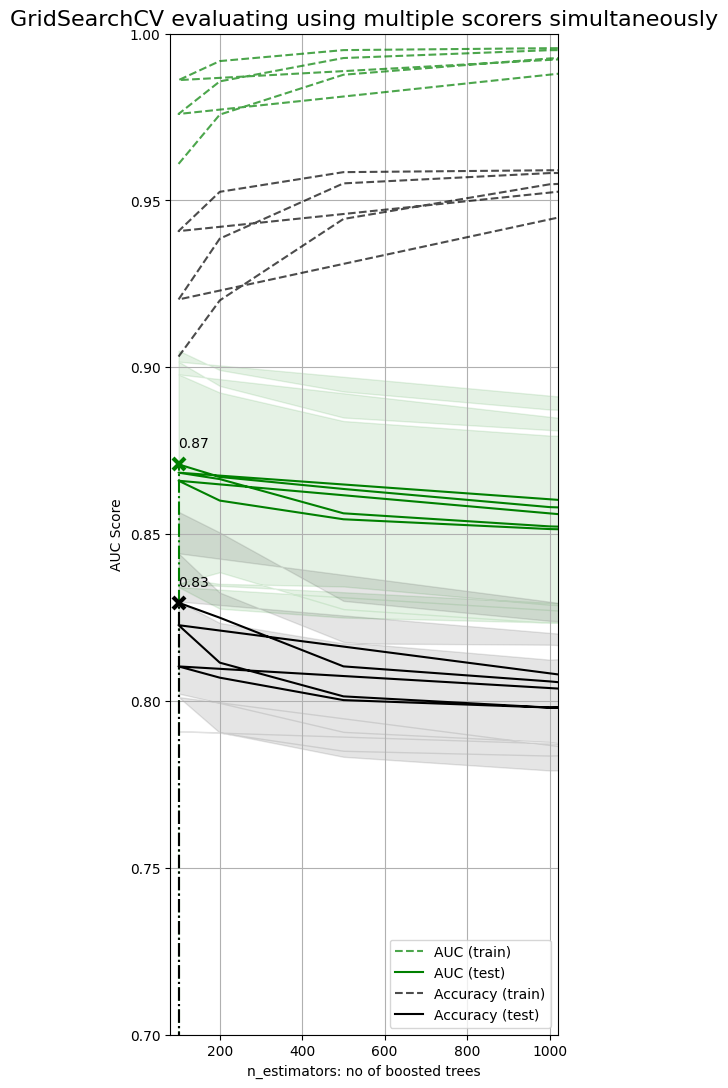

In [47]:
results = clf.cv_results_
#시각화
plt.figure(figsize=(5, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_estimators: no of boosted trees")
plt.ylabel("AUC Score")

ax = plt.gca()
ax.set_xlim(80, 1020)
ax.set_ylim(0.7, 1)

X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(both_scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [48]:
# 예측
predictions = clf.predict(test_df[Columns]).astype(int)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':predictions})

In [50]:
submission

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


In [51]:
# Submit
from datetime import datetime
filename = datetime.today().strftime('%Y%m%d') + '_submit.csv'
submission.to_csv("../data/"+filename,index=False)